## Ensemble Model Implementation

Having established a strong performance benchmark with our baseline **LogisticRegression** model,  
we now move to implement more advanced ensemble methods.  

### Objective:
- Train each model **with default parameters** initially to quickly evaluate their out-of-the-box performance.
- Identify the most promising model architectures before investing time in hyperparameter tuning.

### Models to be Implemented:
- **Bagging:** `RandomForestClassifier`  
- **Boosting:** `XGBClassifier`  
- **Advanced Boosting:** `CatBoostClassifier`

### Training and Evaluation:
- Models will be trained on the **balanced training data** (using SMOTE).  
- Evaluation will be done on the **imbalanced test set**.  
- Use our **business-focused evaluation framework** (Recall, Precision, F1-Score) for fair and direct comparison against the baseline.


### Import Dependencies

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
from Scripts.business_focused_evaluator import BusinessModelEvaluator
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
                            classification_report,
                            confusion_matrix,
                            accuracy_score,
                            f1_score,
                            precision_score,
                            recall_score,
                            )
warnings.filterwarnings('ignore')

### Data Loading

In [32]:
X_train = np.load('../Artifacts/X_train.npz', allow_pickle=True)['arr_0']
Y_train = np.load('../Artifacts/Y_train.npz', allow_pickle=True)['arr_0']
X_test = np.load('../Artifacts/X_test.npz', allow_pickle=True)['arr_0']
Y_test = np.load('../Artifacts/Y_test.npz', allow_pickle=True)['arr_0']

### 1. Random Forest Classifier(Bagging)

### 1.1 Training phase

In [17]:
model_rfc = RandomForestClassifier(
                                    n_estimators=200,
                                    max_depth=10,
                                    min_samples_split=10,
                                    min_samples_leaf=5,
                                    random_state=42,
                                    n_jobs=-1
                                    )

model_rfc.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=42)

### 1.2 Inferencing

In [18]:
Y_hat_test = model_rfc.predict(X_test)

### 1.3 Evaluation with primary metrics

In [19]:
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
F1_score = f1_score(Y_test, Y_hat_test)

In [20]:
print("\n----Random Forest Classifier----")
print(f"precision : {precision}")
print(f"Recall : {recall}")
print(f"F1_score : {F1_score} ")


----Random Forest Classifier----
precision : 0.5640495867768595
Recall : 0.7319034852546917
F1_score : 0.6371061843640606 


### 1.4 Evaluate with Business Focussed Metrics

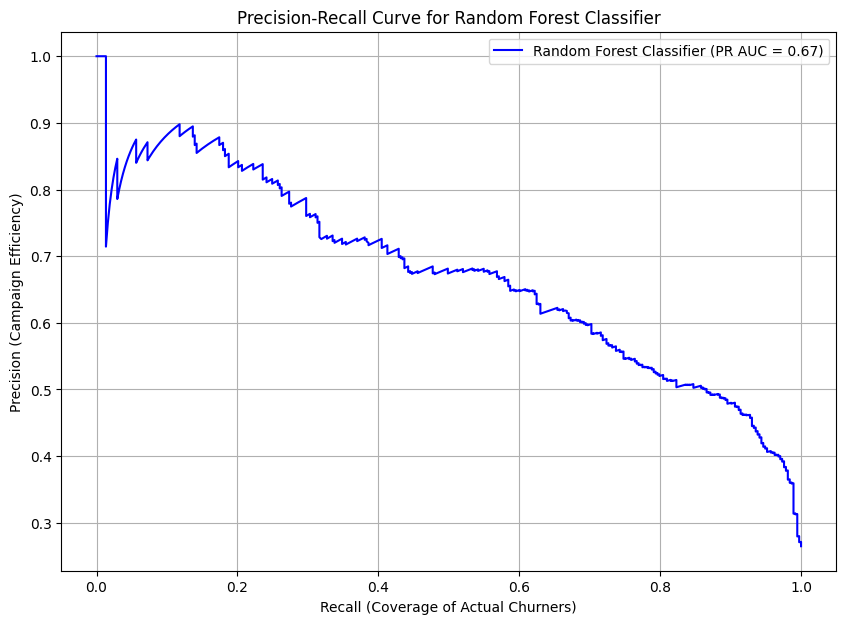

Precision-Recall AUC for Random Forest Classifier: 0.6722

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 211 -> Cost: $10,550.00
False Negatives (FN): 100 -> Cost: $200,000.00
Total Business Cost: $210,550.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.1064
Minimum Achievable Business Cost: $40,900.00

--- Cost-Sensitive Analysis at Threshold = 0.10637320769189883 ---
False Positives (FP): 658 -> Cost: $32,900.00
False Negatives (FN): 4 -> Cost: $8,000.00
Total Business Cost: $40,900.00


np.int64(40900)

In [21]:
COST_FP = 50
COST_FN = 2000

y_probs_rfc = model_rfc.predict_proba(X_test)[: , 1]

# create instnce of the evaluator for model_rfc
rfc_evaluator = BusinessModelEvaluator(
                                    Y_test,
                                    y_probs_rfc,
                                    'Random Forest Classifier'
                                    )

rfc_evaluator.plot_precision_recall_curve()
rfc_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN) 
optimal_thresh, min_cost = rfc_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
rfc_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh) 

### 1.5 Feaure importance Interpretation and Business Insights

In [38]:
# Load the saved pipeline object from the file
full_pipeline = joblib.load('../Artifacts/preprocessing_pipeline.joblib')

print("Preprocessing pipeline loaded successfully!")

Preprocessing pipeline loaded successfully!


In [39]:
# Get the final preprocessor step from the fitted pipeline
final_preprocessor = full_pipeline.named_steps['final_preprocessor']

# Get the feature names in the correct order
raw_feature_names = final_preprocessor.get_feature_names_out()

# Clean up the names to remove the prefixes for better readability
feature_names = [name.replace('num__', '').replace('cat__', '') for name in raw_feature_names]

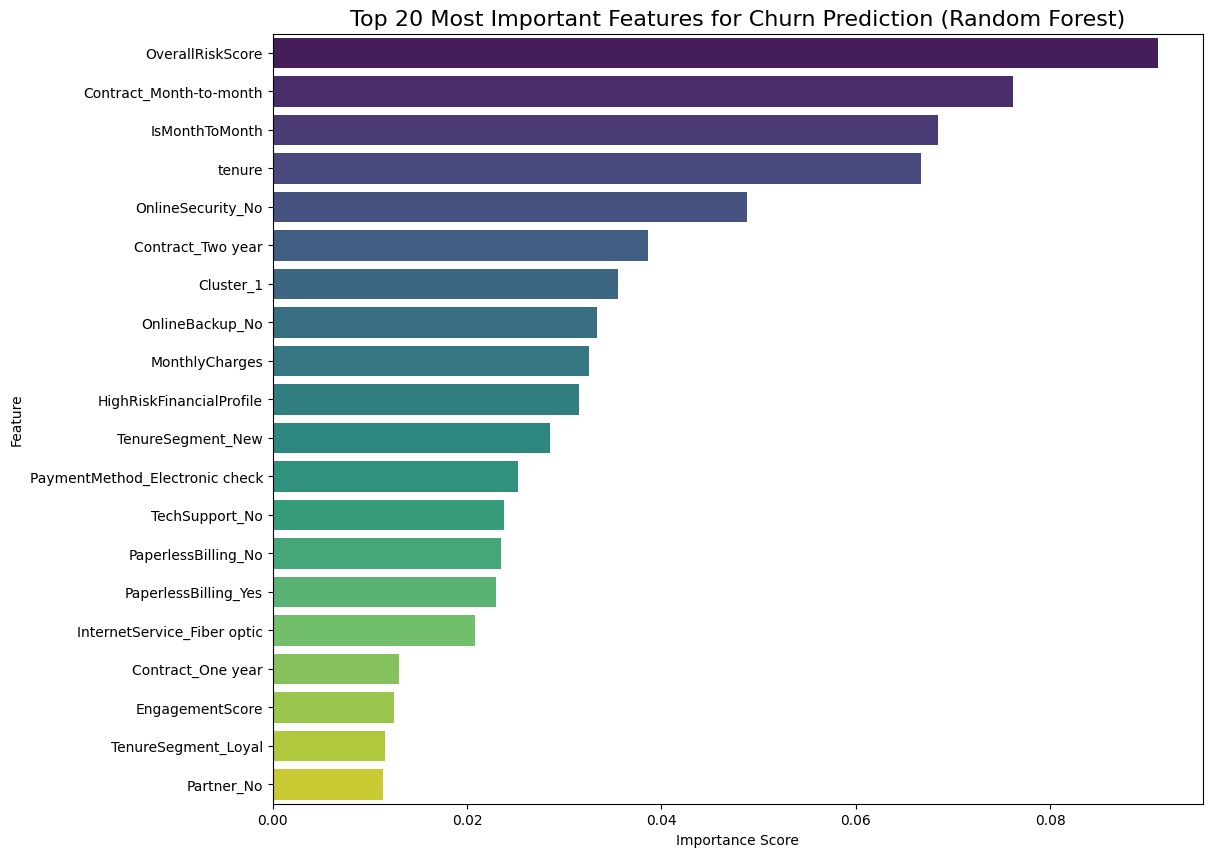

--- Top 10 Most Important Features ---
                     feature  importance
3           OverallRiskScore    0.091151
40   Contract_Month-to-month    0.076210
5             IsMonthToMonth    0.068503
0                     tenure    0.066744
22         OnlineSecurity_No    0.048846
42         Contract_Two year    0.038565
81                 Cluster_1    0.035549
25           OnlineBackup_No    0.033359
1             MonthlyCharges    0.032519
7   HighRiskFinancialProfile    0.031509


In [24]:
# Create a DataFrame of Feature Importances 
importances = model_rfc.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualize the Top 20 Features 
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Churn Prediction (Random Forest)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Print the Top 10 Features
print("--- Top 10 Most Important Features ---")
print(feature_importance_df.head(10))


### Random Forest: Business Insights from Feature Importance

The feature importance analysis from our trained Random Forest model provides a powerful, data-driven confirmation of our earlier findings. By ranking features based on their predictive power, we can definitively identify the most critical drivers of customer churn.

### Key Findings

- **Engineered Features are Extremely Powerful:**  
  Our custom-built features dominate the top of the list. `OverallRiskScore` is the single most important predictor, proving that combining multiple risk factors into one score is highly effective. Other features like `IsMonthToMonth` and `HighRiskFinancialProfile` also rank in the top 10, validating our entire feature engineering process.

- **Contract & Tenure are Paramount:**  
  The model confirms that the customer's commitment level is a primary driver of churn. `Contract_Month-to-month` and `tenure` are among the top 5 most important features. This reinforces that new customers on flexible contracts are the most vulnerable segment.

- **Lack of Protective Services is a Major Red Flag:**  
  The model places high importance on the absence of key services, specifically `OnlineSecurity_No` and `OnlineBackup_No`. This provides strong evidence that customers who do not invest in these protective add-ons are significantly more likely to churn.

- **Behavioral Segments are Highly Predictive:**  
  The presence of `Cluster_1` in the top 10 most important features is a fantastic result. It proves that the customer personas we discovered through unsupervised clustering are not just descriptive but are also highly predictive of churn behavior.

### Strategic Implications

- **Validate the Risk Score:**  
  The model's reliance on `OverallRiskScore` confirms it is a reliable tool. This score could be used by the business to proactively segment and monitor customers in a live environment.

- **Focus on Early-Stage Interventions:**  
  The high importance of `tenure` and `Contract_Month-to-month` directs the business to focus retention efforts on new customers, specifically by creating incentives to move them off month-to-month plans after an initial period.

- **Targeted Upselling as a Retention Tool:**  
  The importance of lacking `OnlineSecurity` and `OnlineBackup` provides a clear action plan: proactively market these specific services as a bundle to at-risk customers to increase their engagement and reduce their likelihood of churning.


### 2. XGBoost (Boosting)

### 2.1 Training Phase

In [25]:
model_xgb = XGBClassifier(
                        n_estimators=200,      
                        max_depth=5,          
                        learning_rate=0.1,      
                        subsample=0.8,          
                        colsample_bytree=0.8,   
                        use_label_encoder=False,
                        eval_metric='logloss', 
                        random_state=42,
                        n_jobs=-1
                        )

model_xgb.fit(X_train, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=-1,
              num_parallel_tree=None, ...)

### 2.2 Inferencing

In [26]:
Y_hat_test = model_xgb.predict(X_test)

### 2.3 Evaluation with primary metrics

In [27]:
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
F1_score = f1_score(Y_test, Y_hat_test)

In [28]:
print("\n----XGBoost Classifier----")
print(f"precision : {precision}")
print(f"Recall : {recall}")
print(f"F1_score : {F1_score} ")


----XGBoost Classifier----
precision : 0.6312849162011173
Recall : 0.6058981233243967
F1_score : 0.6183310533515732 


### 2.4 Evaluate with Business Focussed Metrics

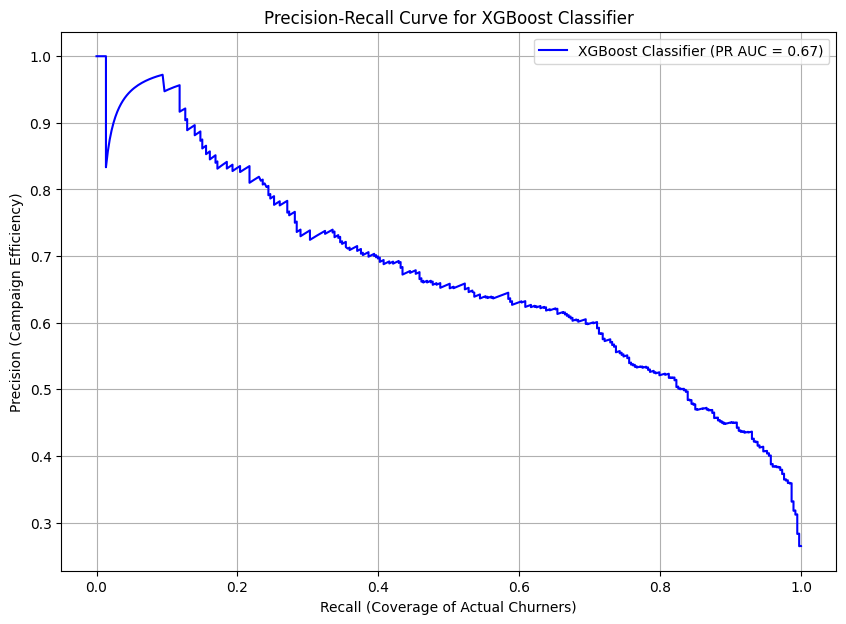

Precision-Recall AUC for XGBoost Classifier: 0.6702

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 132 -> Cost: $6,600.00
False Negatives (FN): 147 -> Cost: $294,000.00
Total Business Cost: $300,600.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.0426
Minimum Achievable Business Cost: $42,850.00

--- Cost-Sensitive Analysis at Threshold = 0.04263122007250786 ---
False Positives (FP): 657 -> Cost: $32,850.00
False Negatives (FN): 5 -> Cost: $10,000.00
Total Business Cost: $42,850.00


np.int64(42850)

In [29]:
COST_FP = 50
COST_FN = 2000

y_probs_xgb = model_xgb.predict_proba(X_test)[: , 1]

# create instnce of the evaluator for model_xgb
xgb_evaluator = BusinessModelEvaluator(
                                    Y_test,
                                    y_probs_xgb,
                                    'XGBoost Classifier'
                                    )

xgb_evaluator.plot_precision_recall_curve()
xgb_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN) 
optimal_thresh, min_cost = xgb_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
xgb_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh) 

### 2.5 Feaure importance Interpretation and Business Insights

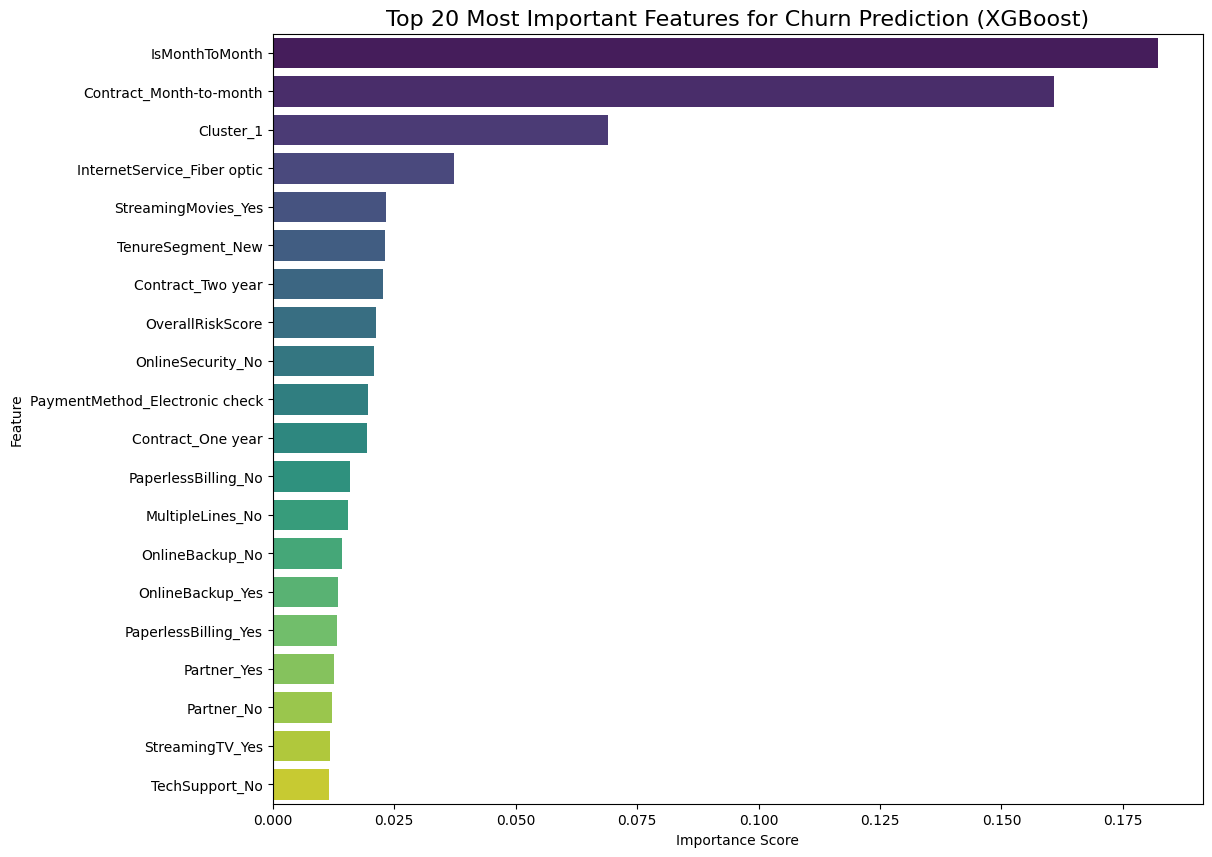

--- Top 10 Most Important Features ---
                           feature  importance
5                   IsMonthToMonth    0.182316
40         Contract_Month-to-month    0.160806
81                       Cluster_1    0.069006
20     InternetService_Fiber optic    0.037236
39             StreamingMovies_Yes    0.023246
51               TenureSegment_New    0.023013
42               Contract_Two year    0.022633
3                 OverallRiskScore    0.021182
22               OnlineSecurity_No    0.020745
47  PaymentMethod_Electronic check    0.019510


In [30]:
# Create a DataFrame of Feature Importances 
importances = model_xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualize the Top 20 Features 
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Churn Prediction (XGBoost)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Print the Top 10 Features
print("--- Top 10 Most Important Features ---")
print(feature_importance_df.head(10))


### XGBoost: Business Insights from Feature Importance

The feature importance analysis from our XGBoost model provides a powerful confirmation of our key findings, with a distinct emphasis on the overwhelming importance of a customer's contractual and financial commitment.

#### Key Findings

- **Contractual Commitment is the Dominant Factor:**  
  The top two most important features, `IsMonthToMonth` and `Contract_Month-to-month`, account for a massive portion of the model's predictive power. This is an even stronger signal than what we saw with Random Forest. It suggests that a customer's decision to be on a flexible, non-committal contract is the single most critical indicator of churn risk.

- **Behavioral Segments are Highly Predictive:**  
  The high importance of `Cluster_1` is a standout result. This proves that the *"At-Risk Basic User"* persona we identified through unsupervised clustering (new, low-tenure, month-to-month DSL users) represents a real and highly predictable segment of the customer base. This validates our segmentation strategy.

- **Service Type is a Key Differentiator:**  
  The model confirms that `InternetService_Fiber optic` is a major driver of churn. This reinforces the need for a specific strategy to manage the risk associated with this premium product.

#### Strategic Implications

- **Aggressively Target Month-to-Month Customers:**  
  Given the overwhelming importance of this feature, the highest ROI for retention efforts will come from a laser-focused campaign to move customers from month-to-month plans to longer-term contracts.

- **Leverage Customer Personas:**  
  The high importance of `Cluster_1` proves that a one-size-fits-all retention strategy is not optimal. The business should design specific interventions tailored to the needs and behaviors of the different customer segments we've identified.

- **Address the Fiber Optic Paradox:**  
  The continued high importance of this feature confirms that retention strategies must directly address the challenges faced by Fiber optic customers, likely through the targeted upselling of protective services as identified in our interaction analysis.


### 3. CatBoost (Advanced Boosting)

### 3.1 Training Phase

In [33]:
model_ctb = CatBoostClassifier(
                            iterations=200,
                            learning_rate=0.1,
                            depth=5,
                            verbose=0,
                            random_state=42
                            )

model_ctb.fit(X_train, Y_train)

### 3.2 Inferencing

In [34]:
model_ctb.predict(X_test)

array([1, 0, 0, ..., 0, 0, 1], shape=(1409,))

### 3.3 Evaluation with primary metrics

In [35]:
precision = precision_score(Y_test, Y_hat_test)
recall = recall_score(Y_test, Y_hat_test)
F1_score = f1_score(Y_test, Y_hat_test)

In [36]:
print("\n----CatBoost Classifier----")
print(f"precision : {precision}")
print(f"Recall : {recall}")
print(f"F1_score : {F1_score} ")


----CatBoost Classifier----
precision : 0.6312849162011173
Recall : 0.6058981233243967
F1_score : 0.6183310533515732 


### 3.4 Evaluation with Business focussed metrics

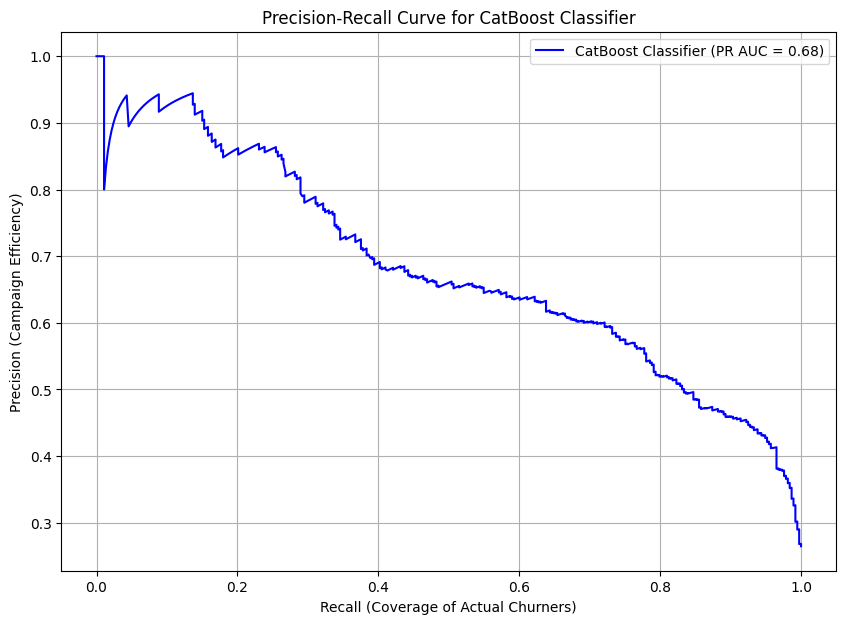

Precision-Recall AUC for CatBoost Classifier: 0.6811

--- Cost-Sensitive Analysis at Threshold = 0.5 ---
False Positives (FP): 133 -> Cost: $6,650.00
False Negatives (FN): 141 -> Cost: $282,000.00
Total Business Cost: $288,650.00

--- Threshold Optimization ---
Optimal Threshold for Minimum Business Cost: 0.0438
Minimum Achievable Business Cost: $43,800.00

--- Cost-Sensitive Analysis at Threshold = 0.04379822714258238 ---
False Positives (FP): 676 -> Cost: $33,800.00
False Negatives (FN): 5 -> Cost: $10,000.00
Total Business Cost: $43,800.00


np.int64(43800)

In [37]:
COST_FP = 50
COST_FN = 2000

y_probs_ctb = model_ctb.predict_proba(X_test)[: , 1]

# create instnce of the evaluator for modelctb
ctb_evaluator = BusinessModelEvaluator(
                                    Y_test,
                                    y_probs_ctb,
                                    'CatBoost Classifier'
                                    )

ctb_evaluator.plot_precision_recall_curve()
ctb_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN) 
optimal_thresh, min_cost = ctb_evaluator.find_optimal_threshold(cost_fp=COST_FP, cost_fn=COST_FN)
ctb_evaluator.cost_sensitive_analysis(cost_fp=COST_FP, cost_fn=COST_FN, threshold=optimal_thresh) 

### 3.5 Feaure importance Interpretation and Business Insights

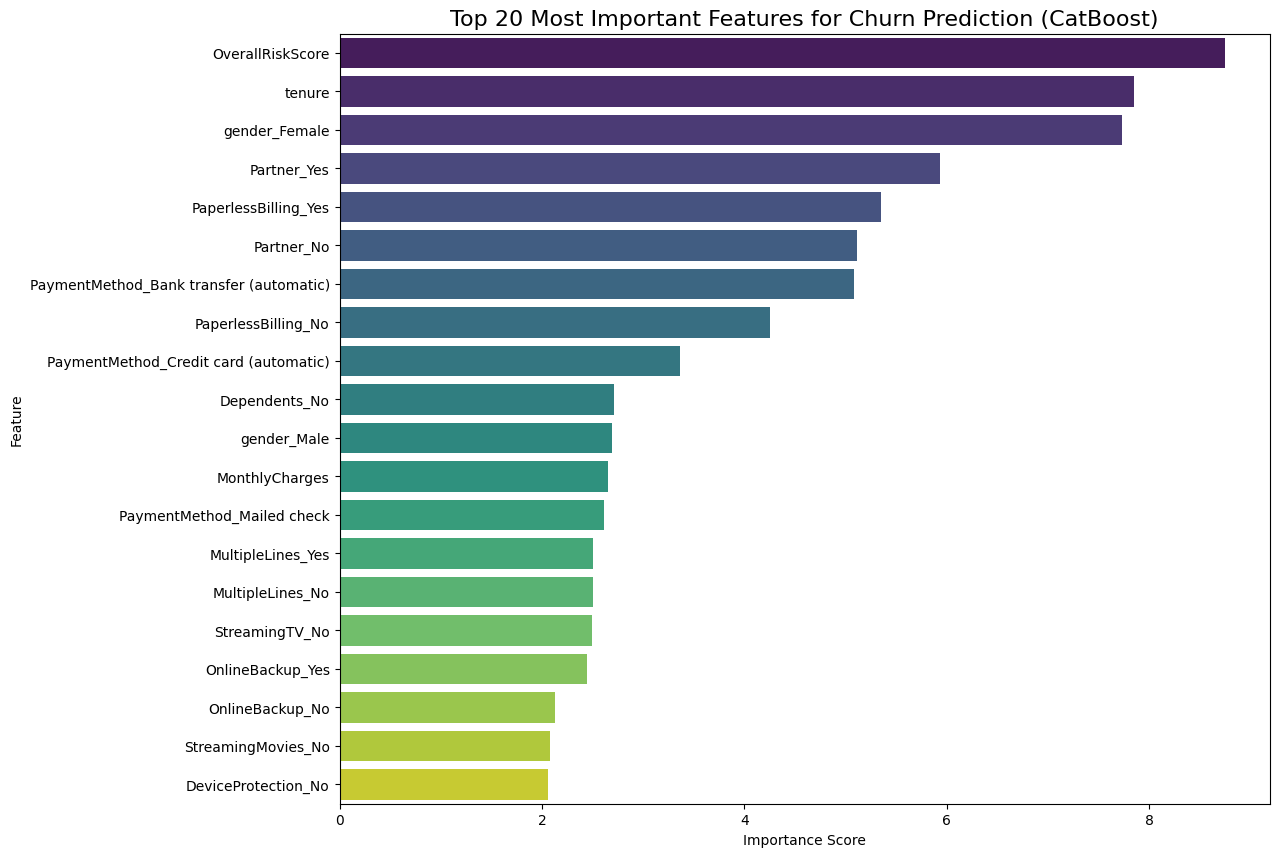

--- Top 10 Most Important Features ---
                                    feature  importance
3                          OverallRiskScore    8.753449
0                                    tenure    7.852483
8                             gender_Female    7.733049
11                              Partner_Yes    5.933930
44                     PaperlessBilling_Yes    5.347491
10                               Partner_No    5.109683
45  PaymentMethod_Bank transfer (automatic)    5.087440
43                      PaperlessBilling_No    4.251707
46    PaymentMethod_Credit card (automatic)    3.361068
12                            Dependents_No    2.715037


In [40]:
# Create a DataFrame of Feature Importances 
importances = model_ctb.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Visualize the Top 20 Features 
plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Most Important Features for Churn Prediction (CatBoost)', fontsize=16)
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# Print the Top 10 Features
print("--- Top 10 Most Important Features ---")
print(feature_importance_df.head(10))


### CatBoost: Business Insights from Feature Importance

The feature importance analysis from our CatBoost model provides a unique perspective on the drivers of churn. While it confirms some of our previous findings, it also elevates the importance of demographic and relationship-status features, suggesting it has uncovered more nuanced patterns in the data.

#### Key Findings

- **Engineered Score and Tenure Remain Supreme:**  
  Consistent with our other models, the top two most important features are our engineered `OverallRiskScore` and the customer's `tenure`. This provides a powerful, cross-model validation that a customer's loyalty and their overall risk profile are the most critical predictors of churn.

- **Demographics Emerge as Key Predictors:**  
  In a significant departure from the other models, CatBoost has identified `gender_Female`, `Partner_Yes`, and `Dependents_No` as top-tier predictors. This suggests that CatBoost's sophisticated handling of feature interactions has found that these demographic attributes, when combined with other behaviors, have a strong influence on the likelihood of churning.

- **Billing and Payment Preferences are Crucial:**  
  The high importance of `PaperlessBilling_Yes` and specific payment methods like `Bank transfer (automatic)` and `Credit card (automatic)` confirms that how a customer chooses to interact with the company financially is a strong behavioral signal. Customers who opt for convenient, "set-it-and-forget-it" methods are likely more stable.

#### Strategic Implications

- **Consider Personalization in Retention Campaigns:**  
  The high importance of demographic features suggests that a one-size-fits-all retention strategy may not be optimal. The business could test personalized marketing campaigns with messaging tailored to different demographic segments (e.g., customers with partners vs. those without).

- **Double Down on the OverallRiskScore:**  
  The fact that all three of our advanced models agree that `OverallRiskScore` is a top predictor provides a very strong signal to the business. This score should be considered a reliable and essential tool for proactively identifying and managing at-risk customers.

- **Promote Automated and Seamless Interactions:**  
  The model's focus on billing and payment methods reinforces the need to make customer interactions as frictionless as possible. Actively promoting automatic payments and easy-to-use digital billing can be a subtle but effective long-term retention strategy.


### 4. Performance Comparison Framework

In [41]:
model_results = {
    'Logistic Regression': {
        'Precision (Optimal)': 0.5280,
        'Recall (Optimal)': 0.8097,
        'F1-Score (Optimal)': 0.6392,
        'Min Business Cost': 41150.00,
        'PR AUC': 0.67,
        'Optimal Threshold': 0.0736
    },
    'Decision Tree': {
        'Precision (Optimal)': 0.47,
        'Recall (Optimal)': 0.51,
        'F1-Score (Optimal)': 0.49,
        'Min Business Cost': 51800.00,
        'PR AUC': 0.56,
        'Optimal Threshold': 0.0
    },
    'Random Forest': {
        'Precision (Optimal)': 0.5640,
        'Recall (Optimal)': 0.7319,
        'F1-Score (Optimal)': 0.6371,
        'Min Business Cost': 40900.00,
        'PR AUC': 0.67,
        'Optimal Threshold': 0.1064
    },
    'XGBoost': {
        'Precision (Optimal)': 0.6313,
        'Recall (Optimal)': 0.6059,
        'F1-Score (Optimal)': 0.6183,
        'Min Business Cost': 42850.00,
        'PR AUC': 0.67,
        'Optimal Threshold': 0.0426
    },
    'CatBoost': {
        'Precision (Optimal)': 0.6313,
        'Recall (Optimal)': 0.6059,
        'F1-Score (Optimal)': 0.6183,
        'Min Business Cost': 43800.00,
        'PR AUC': 0.67,
        'Optimal Threshold': 0.0438
    }
}